Found 546 ORD dataset files under /home/pyl/datasets/ord-data/data
Loading data with up to 48 threads...
Failed to load /home/pyl/datasets/ord-data/data/6a/ord_dataset-6a0bfcdf53a64c07987822162ae591e2.pb.gz: reaction contains no valid reactants or products
Total ORD reactions processed after the filter: 1


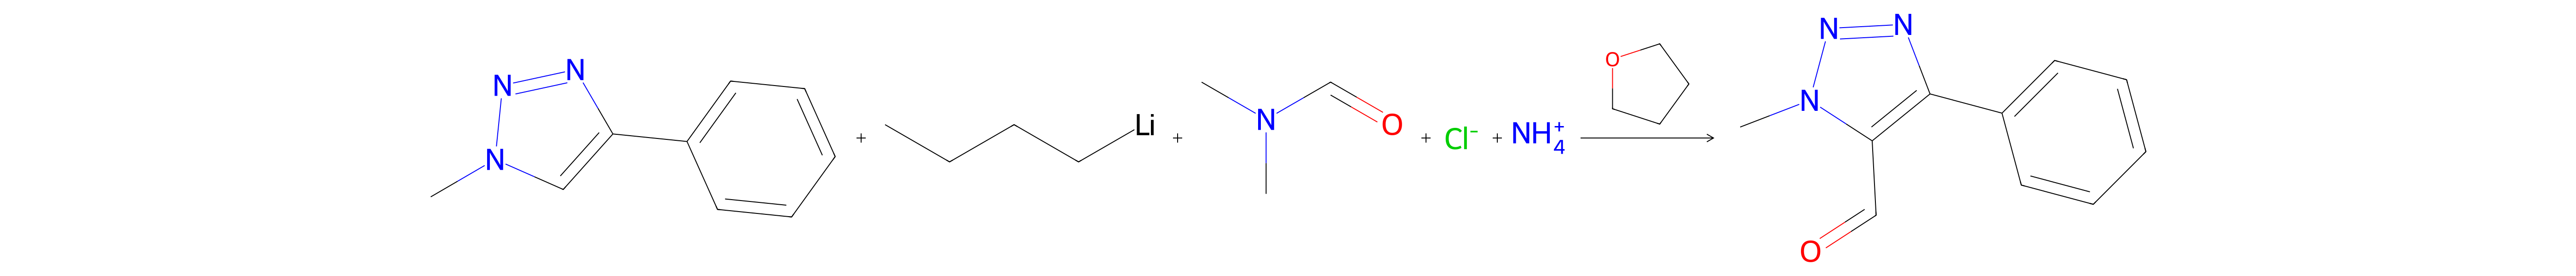

reaction_id,ord-ee94013090da459791dcd4df31f4e82a
reaction_index,2034
procedure,"{'conditions.temperature.setpoint.value': -75.0, 'conditions.temperature.setpoint.units': 'CELSIUS', 'conditions.stirring.type': 'CUSTOM', 'conditions.stirring.details': 'The resulted orange solution was stirred at −75° C. for 40 min', 'conditions.conditions_are_dynamic': True, 'conditions.details': 'See reaction.notes.procedure_details.', 'notes.procedure_details': 'To a solution of 1-methyl-4-phenyl-1H-[1,2,3]triazole (165 mg, 1.04 mmol) in THF (5.2 mL) was added n-BuLi (1.6 M in hexane, 777 μL, 1.24 mmol) dropwise at −75° C. under Argon. The resulted orange solution was stirred at −75° C. for 40 min, then DMF (104 μL, 1.35 mmol) was added dropwise at −75° C. and the reaction mixture was allowed to warm up to room temperature over 1 h. The mixture was then poured into saturated ammonium chloride solution and extracted with ethyl acetate and the combined organic extracts washed with brine, dried over sodium sulphate, filtered and evaporated. Purification by chromatography (silica, 0 to 50% ethyl acetate in heptane) afforded the title compound (131 mg, 68%) as a white solid. MS: m/e=187.0 [M]+.'}"
yields,"[{'product_smiles': 'Cn1nnc(-c2ccccc2)c1C=O', 'yield_percent': 68.0}]"


In [1]:
"""
Example usage of chemrxn-cleaner on ORD data aggregated from a local dataset directory.

Run with:
    python examples/clean_data_example.py
"""
from rdkit import RDLogger

# Disable all RDKit logs
RDLogger.DisableLog('rdApp.*')

from __future__ import annotations

import os
from concurrent.futures import ThreadPoolExecutor, as_completed
from pathlib import Path
from typing import Any, Dict, List, Tuple

from chemrxn_cleaner.loader import load_uspto_rsmi, load_ord_pb_reaction_smiles
from chemrxn_cleaner.extractor import ord_procedure_yields_meta
from chemrxn_cleaner.cleaning import clean_reactions
from chemrxn_cleaner.filters import default_filters, max_smiles_length, element_filter
from chemrxn_cleaner.reporting import summarize_cleaning
from chemrxn_cleaner.types import ElementFilterRule, ReactionRecord
from chemrxn_cleaner.similarity import similarity_filter
from chemrxn_cleaner.io import export_reaction_records_to_json, load_reaction_records_from_json

DATA_ROOT = Path("/home/pyl/datasets/ord-data/data")


def get_ord_dataset_files(root: Path) -> List[Path]:
    ord_files: List[Path] = []
    for path in root.rglob("*"):
        if not path.is_file():
            continue
        suffix = "".join(path.suffixes).lower()
        if suffix.endswith(".pb") or suffix.endswith(".pb.gz"):
            ord_files.append(path)
    return sorted(ord_files)


dataset_files = get_ord_dataset_files(DATA_ROOT)
print(f"Found {len(dataset_files)} ORD dataset files under {DATA_ROOT}")

def load_and_clean_ord_file(path: Path) -> List[ReactionRecord]:
    rxn_ord = load_ord_pb_reaction_smiles(
        str(path),
        meta_extractor=ord_procedure_yields_meta,
    )
    # read ORD (Open Reaction Database) data from your local environment
    TEST = "Cn2cc(c1ccccc1)nn2"
    return clean_reactions(rxn_smiles_list=rxn_ord, filters=[
        max_smiles_length(500),
        similarity_filter(query_smiles=TEST, role='any', threshold=0.7)
    ])


rxn_processed: List[ReactionRecord] = []

if dataset_files:
    cpu_workers = os.cpu_count() or 4
    max_workers = max(1, min(len(dataset_files), cpu_workers * 2))
    print(f"Loading data with up to {max_workers} threads...")
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(load_and_clean_ord_file, path): path for path in dataset_files}
        for future in as_completed(futures):
            path = futures[future]
            try:
                reactions = future.result()
            except Exception as exc:
                print(f"Failed to load {path}: {exc}")
                continue
            # Load each ORD file concurrently to keep pace with the large dataset.
            rxn_processed.extend(reactions)
else:
    print(f"No ORD dataset files found in {DATA_ROOT}")

print(f"Total ORD reactions processed after the filter: {len(rxn_processed)}")

export_reaction_records_to_json(records=rxn_processed, path='./export.json')

rxn_from_file = load_reaction_records_from_json(path='./export.json')

for rxn in rxn_from_file[0:10]:
    rxn.show()


